# Practice Problem 3

Here we are trying to replicate Figure 1.4 of Bolker. We start out with a standard import of the tools we'll be using (copied from the previous PP, so not all of this is necessary!)

In [16]:
# Import numerical tools
import numpy as np

# Import statistical tools
from scipy import stats
np.random.seed(12345678) #If you specify a random seed, it will initialize the random number
    #generator the same way each time, making your results reproducible each time you rerun
    #the code. Note that multiple draws of a random number within the same session will still 
    #return different values.
    
import scipy.misc #We need to include this to get access to the combinatorical functions.

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

%config InlineBackend.figure_formats = {'svg',}
#%config InlineBackend.figure_formats = {'png', 'retina'}

#Import pandas for reading in and managing data
import pandas as pd

#Import seaborn (useful for plotting - makes plots pretty)
import seaborn as sns

Next, our task is to reproduce the figure, using the likelihood formula derived in class.

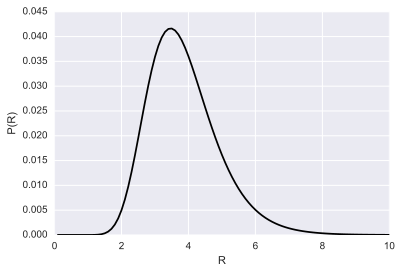

In [50]:
R = np.arange(0.1, 10.1, 0.1) # Let's create a range of test values of the predation ratio for
    # this calculation.
p_h = np.ones(len(R))/len(R) # This makes an array of ones and divides it by the total array
    # length. Effectively, it creates a uniform prior probability for each hypothesized value
    # of R (a.k.a., an "uninformed prior")

# Now, let's calculate the likelihood of getting the observed data associated with each value 
    # of R.

L = np.zeros(len(R)) #Initialize the array to be the same size as R.

for i in range(len(R)): #Iterate over all of the values of R
    R_i = R[i] 
    L[i]=(scipy.misc.comb(210, 26)*(51*R_i/(210*R_i+731))**26*(1-51*R_i/(201*R_i+731))**184
          *scipy.misc.comb(731, 25)*(51/(210*R_i+731))**25*(1-51/(210*R_i+731))**706) # The 
        # likelihood formula we worked out in class notes

#Now, to come up with p(e), we need to sum over the product of each likelihood times the 
# probability of R_i (i.e., from the prior.)

p_e = np.sum(L*p_h)

p_h_e = L*p_h/p_e #Implement Bayes' formula

plt.plot(R, p_h_e, 'k-')
plt.xlabel('R')
plt.ylabel('P(R)')
plt.show()
    

... and it's a match! Now, on to the bonus problem. Descriptions of the rationale are in the comments of the code below.

In [76]:
p_thresh = np.arange(0.0001, 0.01, 0.0001) # This will be an array of threshold probabilities
    # to bisect the plot above with. For each of these threshold probabilities, we will 
    # calculate the area of the curve above that value in order to find the best approximation
    # to the 95% confidence intervals.

area = np.zeros(len(p_thresh)) #Initializes an array in which each entry will represent the area
    # of the curve above each corresponding value of p_thresh.
    
for i in range(len(p_thresh)):
    inds = p_h_e >= p_thresh[i] # Returns an array of True or False, based on whether each 
    # element of p_h_e is greater than or equal to p_thresh.
    area[i] = np.trapz(p_h_e[inds], R[inds]) # Performs numerical integration of that part of the
    # curve above p_thresh.

# Now we need to find the threshold for which 95% of the total area under the curve is above.
# Recall from the lecture notes that, because this is a conditional probability (i.e., probability
# of getting that value of R given the observations), the total area under the curve need not
# sum to one. So we need to solve for the total area under the curve first.

tot_area = np.trapz(p_h_e, R) #Total area under the curve
diff_from_95pct = np.abs(area/tot_area-0.95) # Absolute difference from 95% of area under curve
    # for each threshold
chosen_thresh = np.min(p_thresh[diff_from_95pct==np.min(diff_from_95pct)]) # The threshold that 
    # gives closest to 95% of the area under the curve. Because we are doing these calculations
    # discretely, there are several values that satisfy the equality above, so we are just picking
    # the smallest.
lower_bnd_CI = np.min(R[p_h_e>=chosen_thresh]) # Find the minimum value of R for which p_h_e is
    # greater than the selected threshold. This is the lower bound of the confidence interval.
upper_bnd_CI = np.max(R[p_h_e>=chosen_thresh]) # Find the maximum value of R for which p_h_e is
    # greater than the selected threshold. This is the upper bound of the confidence interval.

print(lower_bnd_CI, upper_bnd_CI)

2.0 6.0


This is the same interval as that depicted in Bolker, so we did pretty well with this approximation. If you got this far, you probably had a bug at some point related to the fact that, with the chosen interval/step for the array of values of p_thresh to test, together with the fact that integration is being done with the trapezoidal rule, several values of p_thresh give you an area that is very close to 95% of the toal area under the curve (this is why we had to just pick one of the possibilities). The confidence intervals could be made more precise by changing the increment with which R is sampled (i.e., making it less than 0.1).